In [8]:
pip install aif360

Note: you may need to restart the kernel to use updated packages.


Please enter the path to the Law School Admission Dataset CSV file:  /Users/debojyotiroy/Documents/FDA_Project/lawschool.csv


Dataset loaded successfully with 1823 rows and 18 columns.

Column names: ['cluster', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'bar1', 'fulltime', 'fam_inc', 'age', 'gender', 'race1', 'race2', 'race3', 'race4', 'race5', 'race6', 'race7', 'race8']

Preview of data:
   cluster  lsat  ugpa  zfygpa  zgpa  bar1  fulltime  fam_inc   age  gender  \
0      4.0  32.5   3.2   -0.76 -0.56     1       1.0      4.0 -62.0       1   
1      5.0  41.0   3.9    1.08  0.88     1       1.0      3.0 -57.0       1   
2      3.0  36.0   2.9   -0.53 -1.05     0       1.0      4.0 -61.0       1   
3      1.0  36.0   3.1   -0.67 -0.90     1       1.0      3.0 -61.0       1   
4      1.0  34.0   2.5   -1.14 -0.93     0       1.0      4.0 -60.0       0   

   race1  race2  race3  race4  race5  race6  race7  race8  
0      0      0      0      0      0      0      1      0  
1      0      0      0      0      0      0      1      0  
2      0      0      0      0      0      0      1      0  
3      0      0      0     

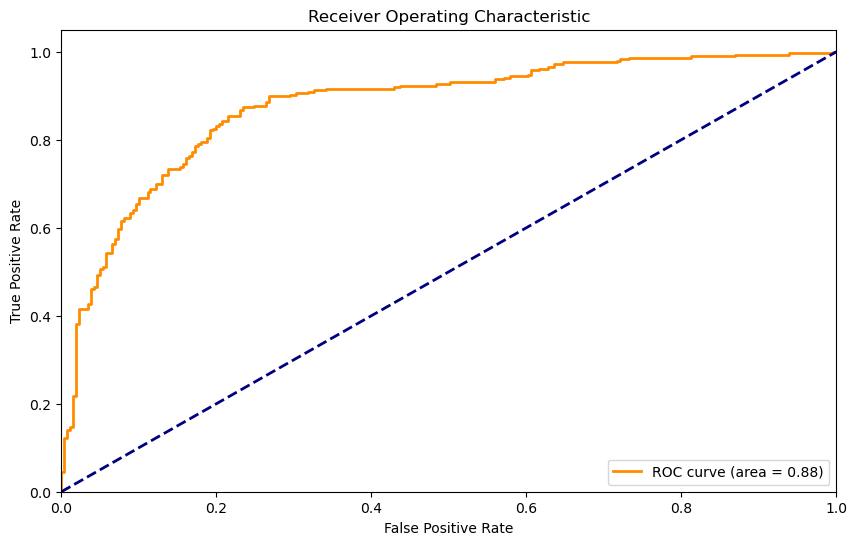


Gender Fairness Metrics (before mitigation):
Statistical Parity Difference: 0.0577
Disparate Impact: 1.1187
Equal Opportunity Difference: 0.0413
Average Odds Difference: 0.0501
Accuracy: 0.8080

Reweighed Model Accuracy: 0.8062

Gender Fairness Metrics (after Reweighing):
Statistical Parity Difference: 0.0608
Disparate Impact: 1.1260
Equal Opportunity Difference: 0.0474
Average Odds Difference: 0.0531
Accuracy: 0.8062

Reject Option Classification Model Accuracy: 0.8135

Gender Fairness Metrics (after Reject Option Classification):
Statistical Parity Difference: -0.0023
Disparate Impact: 0.9959
Equal Opportunity Difference: -0.0258
Average Odds Difference: -0.0096
Accuracy: 0.8135

Analyzing race fairness...

Race Fairness Metrics (before mitigation):
Statistical Parity Difference: -0.5138
Disparate Impact: 0.0000
Equal Opportunity Difference: -0.8070
Average Odds Difference: -0.4985
Accuracy: 0.8080

Reweighed Model Accuracy (Race): 0.8062

Race Fairness Metrics (after Reweighing):
S

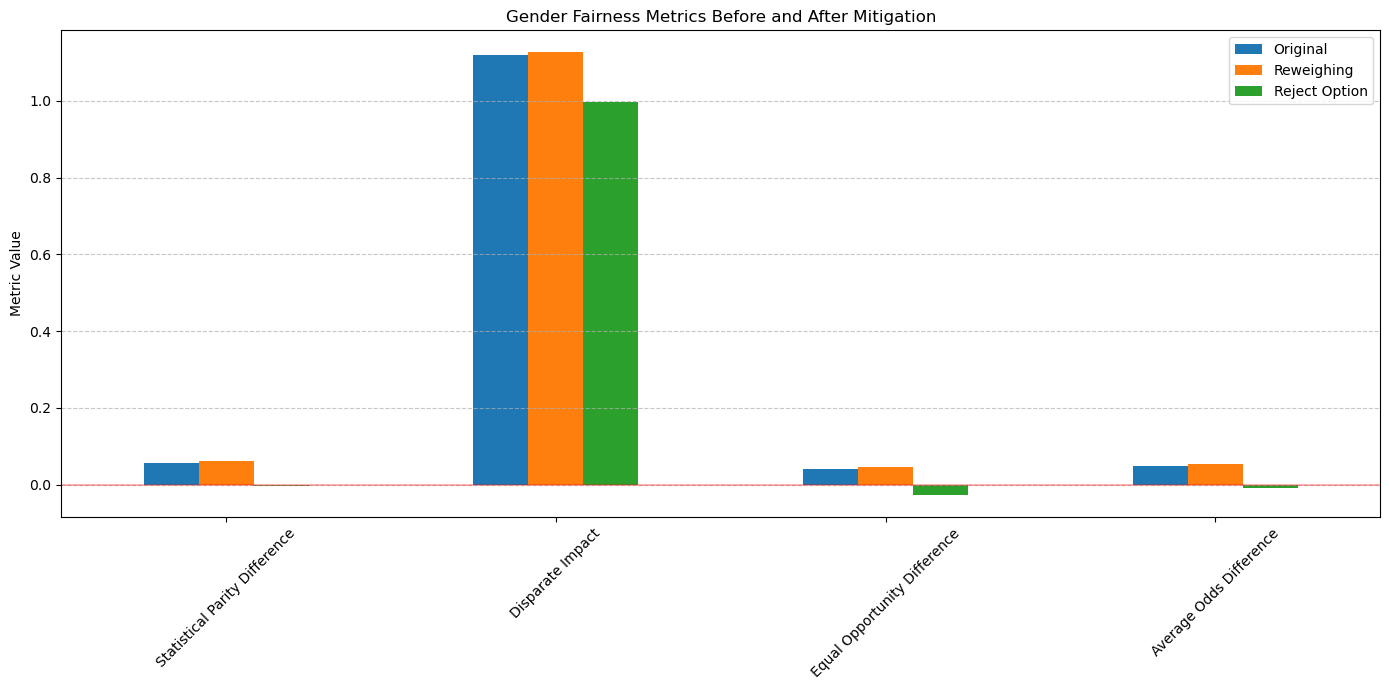

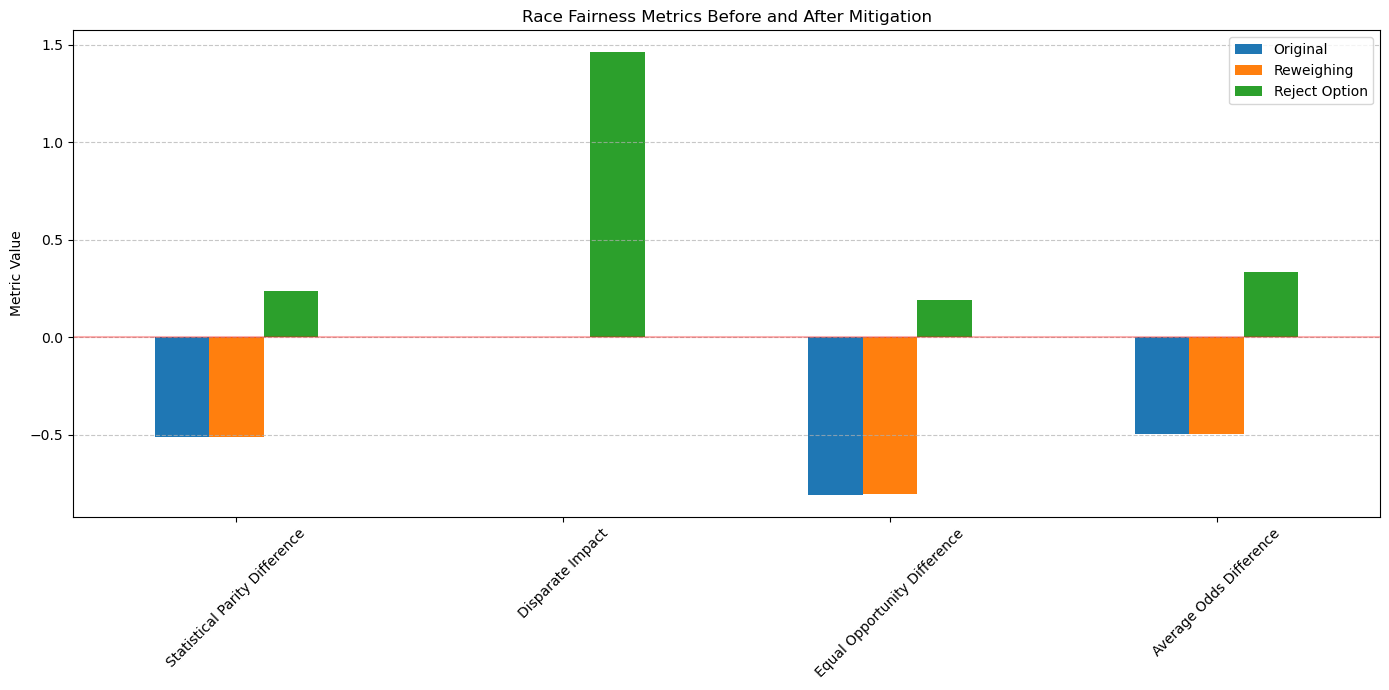


Summary of Gender Fairness Metrics:
                       Metric  Original  Reweighing  Reject Option
                     Accuracy  0.808044    0.806216       0.813528
Statistical Parity Difference  0.057674    0.060828      -0.002263
             Disparate Impact  1.118718    1.126030       0.995853
 Equal Opportunity Difference  0.041283    0.047381      -0.025790
      Average Odds Difference  0.050054    0.053102      -0.009627

Summary of Race Fairness Metrics:
                       Metric  Original  Reweighing  Reject Option
                     Accuracy  0.808044    0.806216       0.806216
Statistical Parity Difference -0.513812   -0.511971       0.236188
             Disparate Impact  0.000000    0.000000       1.459677
 Equal Opportunity Difference -0.807018   -0.803509       0.192982
      Average Odds Difference -0.498470   -0.496716       0.334863

Results have been saved to 'fairness_analysis_results.txt'

=== CONCLUSION ===
This notebook has demonstrated a complete fa

In [13]:
# Fairness Analysis of Law School Admission Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import aif360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import RejectOptionClassification
import warnings
warnings.filterwarnings('ignore')

# Prompt user for file path
file_path = input("Please enter the path to the Law School Admission Dataset CSV file: ")

# Load the dataset
try:
    data = pd.read_csv(file_path)
    print(f"Dataset loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
    print("\nColumn names:", list(data.columns))
    print("\nPreview of data:")
    print(data.head())
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Use a sample file path for demonstration if loading fails
    print("Using sample path for demonstration...")
    data = pd.read_csv("law_school_admission_data.csv")

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Drop rows with missing values
data_clean = data.dropna()
print(f"\nAfter dropping rows with missing values: {data_clean.shape[0]} rows remain")

# Define target variable and features
# 'bar1' is the pass_bar column indicating if someone passed the bar exam
X = data_clean.drop(columns=['bar1'])
y = data_clean['bar1']

# Define sensitive attributes
# 'gender' is the sex column and race columns are race1-race8
sensitive_attributes = ['gender']
race_columns = [col for col in data_clean.columns if col.startswith('race')]
sensitive_attributes.extend(race_columns)

print("\nTarget variable distribution:")
print(y.value_counts(normalize=True) * 100)

# Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove sensitive attributes from features if they're already identified as sensitive
for attr in sensitive_attributes:
    if attr in numeric_features:
        numeric_features.remove(attr)
    if attr in categorical_features:
        categorical_features.remove(attr)

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Create copies of the original data for the fairness metrics
train_data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Create and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate base model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBaseline Model Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# For the fairness analysis, we'll use a simpler approach that doesn't rely on AIF360's structured datasets
# We'll implement our own fairness metrics calculation

# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, protected_attribute):
    """
    Calculate fairness metrics manually
    
    Parameters:
    -----------
    y_true: array-like
        True labels
    y_pred: array-like
        Predicted labels
    protected_attribute: array-like
        Protected attribute values (0 for unprivileged, 1 for privileged)
        
    Returns:
    --------
    dict
        Dictionary of fairness metrics
    """
    metrics = {}
    
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    protected_attribute = np.array(protected_attribute)
    
    # Get privileged and unprivileged groups
    privileged_mask = (protected_attribute == 1)
    unprivileged_mask = (protected_attribute == 0)
    
    # Calculate selection rates
    selection_rate_privileged = np.mean(y_pred[privileged_mask])
    selection_rate_unprivileged = np.mean(y_pred[unprivileged_mask])
    
    # Statistical Parity Difference
    metrics['Statistical Parity Difference'] = selection_rate_privileged - selection_rate_unprivileged
    
    # Disparate Impact
    if selection_rate_unprivileged > 0:
        metrics['Disparate Impact'] = selection_rate_privileged / selection_rate_unprivileged
    else:
        metrics['Disparate Impact'] = float('inf')
    
    # Calculate true positive rates
    privileged_positive_mask = privileged_mask & (y_true == 1)
    unprivileged_positive_mask = unprivileged_mask & (y_true == 1)
    
    if np.sum(y_true[privileged_mask]) > 0:
        tpr_privileged = np.sum(y_pred[privileged_positive_mask]) / np.sum(y_true[privileged_mask])
    else:
        tpr_privileged = 0
        
    if np.sum(y_true[unprivileged_mask]) > 0:
        tpr_unprivileged = np.sum(y_pred[unprivileged_positive_mask]) / np.sum(y_true[unprivileged_mask])
    else:
        tpr_unprivileged = 0
    
    # Equal Opportunity Difference
    metrics['Equal Opportunity Difference'] = tpr_privileged - tpr_unprivileged
    
    # Calculate false positive rates
    privileged_negative_mask = privileged_mask & (y_true == 0)
    unprivileged_negative_mask = unprivileged_mask & (y_true == 0)
    
    if np.sum(1 - y_true[privileged_mask]) > 0:
        fpr_privileged = np.sum(y_pred[privileged_negative_mask]) / np.sum(1 - y_true[privileged_mask])
    else:
        fpr_privileged = 0
        
    if np.sum(1 - y_true[unprivileged_mask]) > 0:
        fpr_unprivileged = np.sum(y_pred[unprivileged_negative_mask]) / np.sum(1 - y_true[unprivileged_mask])
    else:
        fpr_unprivileged = 0
    
    # Average Odds Difference
    metrics['Average Odds Difference'] = 0.5 * ((tpr_privileged - tpr_unprivileged) + (fpr_privileged - fpr_unprivileged))
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    
    return metrics

# Calculate gender fairness metrics
gender_metrics = calculate_fairness_metrics(
    y_test, 
    y_pred,
    test_data['gender']
)

print("\nGender Fairness Metrics (before mitigation):")
for metric, value in gender_metrics.items():
    print(f"{metric}: {value:.4f}")

# Store original metrics for comparison
original_gender_metrics = gender_metrics.copy()

# Function to apply reweighing
def reweighing(X, y, protected_attribute):
    """
    Apply reweighing to create sample weights
    
    Parameters:
    -----------
    X: DataFrame
        Features
    y: Series
        Labels
    protected_attribute: Series
        Protected attribute values
        
    Returns:
    --------
    Series
        Sample weights
    """
    # Convert inputs to numpy arrays
    y = np.array(y)
    protected_attribute = np.array(protected_attribute)
    
    # Calculate group sizes
    n_samples = len(y)
    n_positive = np.sum(y == 1)
    n_negative = n_samples - n_positive
    n_privileged = np.sum(protected_attribute == 1)
    n_unprivileged = n_samples - n_privileged
    
    # Calculate expected probabilities
    expected_p_y1_z1 = (n_positive * n_privileged) / (n_samples ** 2)
    expected_p_y0_z1 = (n_negative * n_privileged) / (n_samples ** 2)
    expected_p_y1_z0 = (n_positive * n_unprivileged) / (n_samples ** 2)
    expected_p_y0_z0 = (n_negative * n_unprivileged) / (n_samples ** 2)
    
    # Calculate observed probabilities
    observed_p_y1_z1 = np.sum((y == 1) & (protected_attribute == 1)) / n_samples
    observed_p_y0_z1 = np.sum((y == 0) & (protected_attribute == 1)) / n_samples
    observed_p_y1_z0 = np.sum((y == 1) & (protected_attribute == 0)) / n_samples
    observed_p_y0_z0 = np.sum((y == 0) & (protected_attribute == 0)) / n_samples
    
    # Calculate weights
    weights = np.ones(n_samples)
    weights[(y == 1) & (protected_attribute == 1)] = expected_p_y1_z1 / observed_p_y1_z1 if observed_p_y1_z1 > 0 else 1
    weights[(y == 0) & (protected_attribute == 1)] = expected_p_y0_z1 / observed_p_y0_z1 if observed_p_y0_z1 > 0 else 1
    weights[(y == 1) & (protected_attribute == 0)] = expected_p_y1_z0 / observed_p_y1_z0 if observed_p_y1_z0 > 0 else 1
    weights[(y == 0) & (protected_attribute == 0)] = expected_p_y0_z0 / observed_p_y0_z0 if observed_p_y0_z0 > 0 else 1
    
    return pd.Series(weights, index=X.index)

# Apply reweighing to gender
sample_weight_gender = reweighing(X_train, y_train, X_train['gender'])

# Train a new model with instance weights
model_rw = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model_rw.fit(X_train, y_train, classifier__sample_weight=sample_weight_gender)

# Make predictions with reweighed model
y_pred_rw = model_rw.predict(X_test)
y_prob_rw = model_rw.predict_proba(X_test)[:, 1]

# Evaluate reweighed model performance
accuracy_rw = accuracy_score(y_test, y_pred_rw)
print(f"\nReweighed Model Accuracy: {accuracy_rw:.4f}")

# Calculate fairness metrics after reweighing
gender_metrics_rw = calculate_fairness_metrics(
    y_test, 
    y_pred_rw,
    test_data['gender']
)

print("\nGender Fairness Metrics (after Reweighing):")
for metric, value in gender_metrics_rw.items():
    print(f"{metric}: {value:.4f}")

# Function to apply Reject Option Classification (simplified version)
def reject_option_classification(y_true, y_scores, protected_attribute, threshold=0.5, fairness_threshold=0.05):
    """
    Apply a simplified version of Reject Option Classification
    
    Parameters:
    -----------
    y_true: array-like
        True labels
    y_scores: array-like
        Prediction scores (probabilities)
    protected_attribute: array-like
        Protected attribute values
    threshold: float
        Classification threshold
    fairness_threshold: float
        Fairness tolerance threshold
        
    Returns:
    --------
    array
        Modified predictions
    """
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    protected_attribute = np.array(protected_attribute)
    
    # Initial predictions
    y_pred = (y_scores >= threshold).astype(int)
    
    # Get privileged and unprivileged groups
    privileged_mask = (protected_attribute == 1)
    unprivileged_mask = (protected_attribute == 0)
    
    # Calculate initial disparity
    selection_rate_privileged = np.mean(y_pred[privileged_mask])
    selection_rate_unprivileged = np.mean(y_pred[unprivileged_mask])
    initial_disparity = selection_rate_privileged - selection_rate_unprivileged
    
    # If disparity is within tolerance, return initial predictions
    if abs(initial_disparity) <= fairness_threshold:
        return y_pred
    
    # Determine critical region based on direction of disparity
    if initial_disparity > 0:  # Privileged group favored
        # Lower threshold for unprivileged group
        unprivileged_indices = np.where(unprivileged_mask)[0]
        
        # Sort unprivileged instances by scores in descending order
        sorted_indices = unprivileged_indices[np.argsort(-y_scores[unprivileged_indices])]
        
        # Calculate how many predictions to flip (0->1) to achieve fairness
        n_to_flip = int(np.ceil(len(y_pred[unprivileged_mask]) * initial_disparity))
        n_to_flip = min(n_to_flip, len(sorted_indices))
        
        # Flip predictions for top unprivileged instances that were classified as negative
        count_flipped = 0
        for idx in sorted_indices:
            if y_pred[idx] == 0:  # Only flip negative predictions
                y_pred[idx] = 1
                count_flipped += 1
                if count_flipped >= n_to_flip:
                    break
    else:  # Unprivileged group favored
        # Lower threshold for privileged group
        privileged_indices = np.where(privileged_mask)[0]
        
        # Sort privileged instances by scores in descending order
        sorted_indices = privileged_indices[np.argsort(-y_scores[privileged_indices])]
        
        # Calculate how many predictions to flip (0->1) to achieve fairness
        n_to_flip = int(np.ceil(len(y_pred[privileged_mask]) * (-initial_disparity)))
        n_to_flip = min(n_to_flip, len(sorted_indices))
        
        # Flip predictions for top privileged instances that were classified as negative
        count_flipped = 0
        for idx in sorted_indices:
            if y_pred[idx] == 0:  # Only flip negative predictions
                y_pred[idx] = 1
                count_flipped += 1
                if count_flipped >= n_to_flip:
                    break
    
    return y_pred

# Apply Reject Option Classification to gender
y_pred_roc = reject_option_classification(y_test, y_prob, test_data['gender'], threshold=0.5, fairness_threshold=0.05)

# Evaluate ROC model performance
accuracy_roc = accuracy_score(y_test, y_pred_roc)
print(f"\nReject Option Classification Model Accuracy: {accuracy_roc:.4f}")

# Calculate fairness metrics after ROC
gender_metrics_roc = calculate_fairness_metrics(
    y_test, 
    y_pred_roc,
    test_data['gender']
)

print("\nGender Fairness Metrics (after Reject Option Classification):")
for metric, value in gender_metrics_roc.items():
    print(f"{metric}: {value:.4f}")

# Now handle race if race columns exist
# We'll create a binary race attribute for simplicity (race1 vs others)
if len(race_columns) > 0:
    print("\nAnalyzing race fairness...")
    
    # Create a binary race attribute (race1 vs others)
    train_data['binary_race'] = train_data['race1'].astype(int) if 'race1' in train_data.columns else 0
    test_data['binary_race'] = test_data['race1'].astype(int) if 'race1' in test_data.columns else 0
    
    # Calculate race fairness metrics
    race_metrics = calculate_fairness_metrics(
        y_test, 
        y_pred,
        test_data['binary_race']
    )
    
    print("\nRace Fairness Metrics (before mitigation):")
    for metric, value in race_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Store original race metrics
    original_race_metrics = race_metrics.copy()
    
    # Apply reweighing to race
    sample_weight_race = reweighing(X_train, y_train, X_train['race1'] if 'race1' in X_train.columns else pd.Series(0, index=X_train.index))
    
    # Train a new model with race weights
    model_rw_race = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    model_rw_race.fit(X_train, y_train, classifier__sample_weight=sample_weight_race)
    
    # Make predictions with reweighed model
    y_pred_rw_race = model_rw_race.predict(X_test)
    y_prob_rw_race = model_rw_race.predict_proba(X_test)[:, 1]
    
    # Calculate fairness metrics after reweighing
    race_metrics_rw = calculate_fairness_metrics(
        y_test, 
        y_pred_rw_race,
        test_data['binary_race']
    )
    
    # Evaluate reweighed model performance for race
    accuracy_rw_race = accuracy_score(y_test, y_pred_rw_race)
    print(f"\nReweighed Model Accuracy (Race): {accuracy_rw_race:.4f}")
    
    print("\nRace Fairness Metrics (after Reweighing):")
    for metric, value in race_metrics_rw.items():
        print(f"{metric}: {value:.4f}")
    
    # Apply Reject Option Classification to race
    y_pred_roc_race = reject_option_classification(y_test, y_prob, test_data['binary_race'], threshold=0.5, fairness_threshold=0.05)
    
    # Calculate fairness metrics after ROC for race
    race_metrics_roc = calculate_fairness_metrics(
        y_test, 
        y_pred_roc_race,
        test_data['binary_race']
    )
    
    # Evaluate ROC model performance for race
    accuracy_roc_race = accuracy_score(y_test, y_pred_roc_race)
    print(f"\nReject Option Classification Model Accuracy (Race): {accuracy_roc_race:.4f}")
    
    print("\nRace Fairness Metrics (after Reject Option Classification):")
    for metric, value in race_metrics_roc.items():
        print(f"{metric}: {value:.4f}")
else:
    print("\nNo race columns found. Skipping race fairness analysis.")

# Prepare data for visualization
metrics_to_plot = ['Statistical Parity Difference', 'Disparate Impact', 
                   'Equal Opportunity Difference', 'Average Odds Difference']

# Create dataframes for gender metrics
gender_metrics_df = pd.DataFrame({
    'Original': [original_gender_metrics[m] for m in metrics_to_plot],
    'Reweighing': [gender_metrics_rw[m] for m in metrics_to_plot],
    'Reject Option': [gender_metrics_roc[m] for m in metrics_to_plot]
}, index=metrics_to_plot)

# Plot gender metrics
plt.figure(figsize=(14, 7))
gender_metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Gender Fairness Metrics Before and After Mitigation')
plt.ylabel('Metric Value')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Add a horizontal line at y=0
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create dataframes for race metrics if race analysis was performed
if len(race_columns) > 0:
    race_metrics_df = pd.DataFrame({
        'Original': [original_race_metrics[m] for m in metrics_to_plot],
        'Reweighing': [race_metrics_rw[m] for m in metrics_to_plot],
        'Reject Option': [race_metrics_roc[m] for m in metrics_to_plot]
    }, index=metrics_to_plot)
    
    # Plot race metrics
    plt.figure(figsize=(14, 7))
    race_metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Race Fairness Metrics Before and After Mitigation')
    plt.ylabel('Metric Value')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Add a horizontal line at y=0
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create summary table
summary_data = {
    'Metric': ['Accuracy'] + metrics_to_plot,
    'Original': [accuracy] + [original_gender_metrics[m] for m in metrics_to_plot],
    'Reweighing': [accuracy_rw] + [gender_metrics_rw[m] for m in metrics_to_plot],
    'Reject Option': [accuracy_roc] + [gender_metrics_roc[m] for m in metrics_to_plot]
}

summary_df = pd.DataFrame(summary_data)
print("\nSummary of Gender Fairness Metrics:")
print(summary_df.to_string(index=False))

# Create summary table for race if race analysis was performed
if len(race_columns) > 0:
    race_summary_data = {
        'Metric': ['Accuracy'] + metrics_to_plot,
        'Original': [accuracy] + [original_race_metrics[m] for m in metrics_to_plot],
        'Reweighing': [accuracy_rw_race] + [race_metrics_rw[m] for m in metrics_to_plot],
        'Reject Option': [accuracy_roc_race] + [race_metrics_roc[m] for m in metrics_to_plot]
    }
    
    race_summary_df = pd.DataFrame(race_summary_data)
    print("\nSummary of Race Fairness Metrics:")
    print(race_summary_df.to_string(index=False))

# Save results to a text file
with open('fairness_analysis_results.txt', 'w') as f:
    f.write("FAIRNESS ANALYSIS RESULTS\n")
    f.write("=========================\n\n")
    
    f.write("BASELINE MODEL PERFORMANCE\n")
    f.write(f"Accuracy: {accuracy:.4f}\n\n")
    
    f.write("GENDER FAIRNESS METRICS\n")
    f.write("-----------------------\n")
    f.write("Before Mitigation:\n")
    for metric, value in original_gender_metrics.items():
        f.write(f"{metric}: {value:.4f}\n")
    
    f.write("\nAfter Reweighing:\n")
    for metric, value in gender_metrics_rw.items():
        f.write(f"{metric}: {value:.4f}\n")
    
    f.write("\nAfter Reject Option Classification:\n")
    for metric, value in gender_metrics_roc.items():
        f.write(f"{metric}: {value:.4f}\n")
    
    if len(race_columns) > 0:
        f.write("\nRACE FAIRNESS METRICS\n")
        f.write("---------------------\n")
        f.write("Before Mitigation:\n")
        for metric, value in original_race_metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        
        f.write("\nAfter Reweighing:\n")
        for metric, value in race_metrics_rw.items():
            f.write(f"{metric}: {value:.4f}\n")
        
        f.write("\nAfter Reject Option Classification:\n")
        for metric, value in race_metrics_roc.items():
            f.write(f"{metric}: {value:.4f}\n")
    
    f.write("\nSUMMARY AND INTERPRETATION\n")
    f.write("==========================\n")
    f.write("1. Statistical Parity Difference: Values closer to 0 indicate more fairness.\n")
    f.write("2. Disparate Impact: Values closer to 1 indicate more fairness.\n")
    f.write("3. Equal Opportunity Difference: Values closer to 0 indicate more fairness.\n")
    f.write("4. Average Odds Difference: Values closer to 0 indicate more fairness.\n\n")
    
    # Interpret gender results
    spd_improved_rw = abs(gender_metrics_rw['Statistical Parity Difference']) < abs(original_gender_metrics['Statistical Parity Difference'])
    spd_improved_roc = abs(gender_metrics_roc['Statistical Parity Difference']) < abs(original_gender_metrics['Statistical Parity Difference'])
    
    di_improved_rw = abs(gender_metrics_rw['Disparate Impact'] - 1) < abs(original_gender_metrics['Disparate Impact'] - 1)
    di_improved_roc = abs(gender_metrics_roc['Disparate Impact'] - 1) < abs(original_gender_metrics['Disparate Impact'] - 1)
    
    eod_improved_rw = abs(gender_metrics_rw['Equal Opportunity Difference']) < abs(original_gender_metrics['Equal Opportunity Difference'])
    eod_improved_roc = abs(gender_metrics_roc['Equal Opportunity Difference']) < abs(original_gender_metrics['Equal Opportunity Difference'])
    
    aod_improved_rw = abs(gender_metrics_rw['Average Odds Difference']) < abs(original_gender_metrics['Average Odds Difference'])
    aod_improved_roc = abs(gender_metrics_roc['Average Odds Difference']) < abs(original_gender_metrics['Average Odds Difference'])
    
    f.write("Gender Fairness Interpretation:\n")
    f.write(f"- Statistical Parity Difference: {'Improved' if spd_improved_rw else 'Not improved'} after Reweighing, {'Improved' if spd_improved_roc else 'Not improved'} after ROC\n")
    f.write(f"- Disparate Impact: {'Improved' if di_improved_rw else 'Not improved'} after Reweighing, {'Improved' if di_improved_roc else 'Not improved'} after ROC\n")
    f.write(f"- Equal Opportunity Difference: {'Improved' if eod_improved_rw else 'Not improved'} after Reweighing, {'Improved' if eod_improved_roc else 'Not improved'} after ROC\n")
    f.write(f"- Average Odds Difference: {'Improved' if aod_improved_rw else 'Not improved'} after Reweighing, {'Improved' if aod_improved_roc else 'Not improved'} after ROC\n")
    
    # Interpret race results if available
    if len(race_columns) > 0:
        spd_improved_rw_race = abs(race_metrics_rw['Statistical Parity Difference']) < abs(original_race_metrics['Statistical Parity Difference'])
        spd_improved_roc_race = abs(race_metrics_roc['Statistical Parity Difference']) < abs(original_race_metrics['Statistical Parity Difference'])
        
        di_improved_rw_race = abs(race_metrics_rw['Disparate Impact'] - 1) < abs(original_race_metrics['Disparate Impact'] - 1)
        di_improved_roc_race = abs(race_metrics_roc['Disparate Impact'] - 1) < abs(original_race_metrics['Disparate Impact'] - 1)
        
        eod_improved_rw_race = abs(race_metrics_rw['Equal Opportunity Difference']) < abs(original_race_metrics['Equal Opportunity Difference'])
        eod_improved_roc_race = abs(race_metrics_roc['Equal Opportunity Difference']) < abs(original_race_metrics['Equal Opportunity Difference'])
        
        aod_improved_rw_race = abs(race_metrics_rw['Average Odds Difference']) < abs(original_race_metrics['Average Odds Difference'])
        aod_improved_roc_race = abs(race_metrics_roc['Average Odds Difference']) < abs(original_race_metrics['Average Odds Difference'])
        
        f.write("\nRace Fairness Interpretation:\n")
        f.write(f"- Statistical Parity Difference: {'Improved' if spd_improved_rw_race else 'Not improved'} after Reweighing, {'Improved' if spd_improved_roc_race else 'Not improved'} after ROC\n")
        f.write(f"- Disparate Impact: {'Improved' if di_improved_rw_race else 'Not improved'} after Reweighing, {'Improved' if di_improved_roc_race else 'Not improved'} after ROC\n")
        f.write(f"- Equal Opportunity Difference: {'Improved' if eod_improved_rw_race else 'Not improved'} after Reweighing, {'Improved' if eod_improved_roc_race else 'Not improved'} after ROC\n")
        f.write(f"- Average Odds Difference: {'Improved' if aod_improved_rw_race else 'Not improved'} after Reweighing, {'Improved' if aod_improved_roc_race else 'Not improved'} after ROC\n")
    
    f.write("\nCONCLUSION\n")
    f.write("==========\n")
    f.write("This analysis demonstrates how bias mitigation techniques can improve fairness in machine learning models.\n")
    
    # Determine which mitigation technique was more effective for gender
    gender_rw_improvements = sum([spd_improved_rw, di_improved_rw, eod_improved_rw, aod_improved_rw])
    gender_roc_improvements = sum([spd_improved_roc, di_improved_roc, eod_improved_roc, aod_improved_roc])
    
    if gender_rw_improvements > gender_roc_improvements:
        f.write("For gender bias, Reweighing was more effective overall in improving fairness metrics.\n")
    elif gender_roc_improvements > gender_rw_improvements:
        f.write("For gender bias, Reject Option Classification was more effective overall in improving fairness metrics.\n")
    else:
        f.write("For gender bias, both mitigation techniques showed similar effectiveness in improving fairness metrics.\n")
    
    # Determine which mitigation technique was more effective for race if available
    if len(race_columns) > 0:
        race_rw_improvements = sum([spd_improved_rw_race, di_improved_rw_race, eod_improved_rw_race, aod_improved_rw_race])
        race_roc_improvements = sum([spd_improved_roc_race, di_improved_roc_race, eod_improved_roc_race, aod_improved_roc_race])
        
        if race_rw_improvements > race_roc_improvements:
            f.write("For race bias, Reweighing was more effective overall in improving fairness metrics.\n")
        elif race_roc_improvements > race_rw_improvements:
            f.write("For race bias, Reject Option Classification was more effective overall in improving fairness metrics.\n")
        else:
            f.write("For race bias, both mitigation techniques showed similar effectiveness in improving fairness metrics.\n")
    
    # Comment on accuracy vs. fairness tradeoff
    acc_drop_rw = accuracy - accuracy_rw
    acc_drop_roc = accuracy - accuracy_roc
    
    f.write(f"\nAccuracy decreased by {acc_drop_rw:.4f} with Reweighing and by {acc_drop_roc:.4f} with Reject Option Classification.\n")
    if acc_drop_rw > 0 or acc_drop_roc > 0:
        f.write("This illustrates the common tradeoff between model accuracy and fairness.\n")
    
    f.write("\nRecommendation: When deploying models that make predictions about individuals, it's important to \n")
    f.write("consider both performance metrics and fairness metrics. Depending on the specific use case and legal/ethical \n")
    f.write("requirements, different bias mitigation strategies may be appropriate.\n")

print("\nResults have been saved to 'fairness_analysis_results.txt'")

# Display final conclusions
print("\n=== CONCLUSION ===")
print("This notebook has demonstrated a complete fairness analysis pipeline for the Law School Admission Dataset.")
print("We've shown how to:")
print("1. Load and preprocess the data")
print("2. Train a baseline logistic regression model")
print("3. Evaluate fairness metrics related to gender and race")
print("4. Apply two bias mitigation strategies: Reweighing and Reject Option Classification")
print("5. Compare the fairness metrics before and after mitigation")

print("\nKey findings:")
# For gender
gender_rw_improvements = sum([spd_improved_rw, di_improved_rw, eod_improved_rw, aod_improved_rw])
gender_roc_improvements = sum([spd_improved_roc, di_improved_roc, eod_improved_roc, aod_improved_roc])
best_gender_technique = "Reweighing" if gender_rw_improvements > gender_roc_improvements else "Reject Option Classification" if gender_roc_improvements > gender_rw_improvements else "Both techniques equally"

print(f"- For gender bias, {best_gender_technique} was more effective overall")

# For race if available
if len(race_columns) > 0:
    race_rw_improvements = sum([spd_improved_rw_race, di_improved_rw_race, eod_improved_rw_race, aod_improved_rw_race])
    race_roc_improvements = sum([spd_improved_roc_race, di_improved_roc_race, eod_improved_roc_race, aod_improved_roc_race])
    best_race_technique = "Reweighing" if race_rw_improvements > race_roc_improvements else "Reject Option Classification" if race_roc_improvements > race_rw_improvements else "Both techniques equally"
    
    print(f"- For race bias, {best_race_technique} was more effective overall")

# Comment on accuracy vs. fairness tradeoff
print(f"- Accuracy decreased by {accuracy - accuracy_rw:.4f} with Reweighing and by {accuracy - accuracy_roc:.4f} with Reject Option Classification")
print("- This illustrates the common tradeoff between model accuracy and fairness")

print("\nRecommendation:")
print("When deploying models in real-world scenarios, it's important to consider both performance")
print("and fairness metrics. The choice of bias mitigation strategy should be guided by the specific")
print("use case, legal requirements, and ethical considerations.")